In [1]:
import numpy as np
from __future__ import division
import sqlite3
import json

In [2]:
sqlitefile = '../data backup/data_backup.sqlite'

In [3]:
sqlitefile_downsampled = '../../jeroendelcour.nl/2016election/data_downsampled.sqlite'

# Create database

In [18]:
# conn = sqlite3.connect(sqlitefile)
# c = conn.cursor()
# c.execute('''CREATE TABLE sanders
#        (datetime       REAL,
#        sentiment      REAL,
#        tweetID        TEXT);''')
# c.execute('''CREATE TABLE trump
#        (datetime       REAL,
#        sentiment      REAL,
#        tweetID        TEXT);''')
# c.execute('''CREATE TABLE clinton
#        (datetime       REAL,
#        sentiment      REAL,
#        tweetID        TEXT);''')
# c.execute('''CREATE TABLE cruz
#        (datetime       REAL,
#        sentiment      REAL,
#        tweetID        TEXT);''')
# c.execute('''CREATE TABLE unknown
#        (datetime       REAL,
#        sentiment      REAL,
#        tweetID        TEXT);''')
# conn.commit()
# conn.close()

# Insert data

In [19]:
# import pandas as pd

In [20]:
# candidates = ['sanders', 'trump', 'clinton', 'cruz', 'unknown']
# for candidate in candidates:
#     data = pd.read_csv('data_'+candidate+'_00000.csv', header=None,
#                    names=['date', 'sentiment', 'tweetID'],
#                    dtype={'date': np.float64, 'sentiment': np.float64, 'tweetID': str})
#     conn = sqlite3.connect(sqlitefile)
#     c = conn.cursor()
#     c.execute('PRAGMA journal_mode=wal')
#     c.executemany('''INSERT INTO '''+candidate+'''(datetime, sentiment, tweetID) VALUES (?, ?, ?)''', np.array(data))
#     conn.commit()
#     conn.close()

# Create downsampled database

In [4]:
conn = sqlite3.connect(sqlitefile_downsampled)
c = conn.cursor()
c.execute('''CREATE TABLE sanders
       (datetime      REAL,
       sentiment      REAL,
       tweet_count    INTEGER);''')
c.execute('''CREATE TABLE trump
       (datetime      REAL,
       sentiment      REAL,
       tweet_count    INTEGER);''')
c.execute('''CREATE TABLE clinton
       (datetime      REAL,
       sentiment      REAL,
       tweet_count    INTEGER);''')
c.execute('''CREATE TABLE cruz
       (datetime      REAL,
       sentiment      REAL,
       tweet_count    INTEGER);''')
conn.commit()
conn.close()

<hr>
# Downsample

In [5]:
bin_size = 60 * 60 * 2 # 2 hours
min_tweets = 1000 # minimum number of tweets for a valid entry

candidates = ['sanders', 'trump', 'clinton', 'cruz']

for candidate in candidates:
    
    conn = sqlite3.connect(sqlitefile_downsampled)
    c = conn.cursor()
#     c.execute('''DELETE FROM '''+candidate+''' WHERE 1=1''')
#     conn.commit()
    c.execute('''SELECT * FROM '''+candidate+''' LIMIT 1;''')
    row = c.fetchone()
    conn.close()
    
    if not row:
        # table is empty, start from scratch

        conn = sqlite3.connect(sqlitefile)
        c = conn.cursor()
        c.execute('''SELECT * FROM '''+candidate+''';''')
        all_rows = c.fetchall()
        conn.close()
        
        prev_time = None
        sentiments = []
        tweet_count = 0
        for row in all_rows:
            sentiments.append(row[1])
            tweet_count += 1
            if not prev_time:
                prev_time = row[0]
                continue
            time = row[0]
            if time - prev_time > bin_size:
                # we've passed bin_size, wrap it up
                if time - prev_time > bin_size*2:
                    # more than 2 bin_sizes have passed, we're missing data. Add an empty entry.
                    conn = sqlite3.connect(sqlitefile_downsampled)
                    c = conn.cursor()
                    c.execute('PRAGMA journal_mode=wal')
                    c.execute('''INSERT INTO '''+candidate+'''(datetime, sentiment, tweet_count) VALUES (?,?,?);''',
                             (time - (time-prev_time)/2, None, tweet_count))
                    conn.commit()
                    conn.close()
                    prev_time = time
                    sentiments = []
                    tweet_count = 0
                elif tweet_count >= min_tweets: # check if we have a reasonable number of tweets to get a mean sentiment from
                    conn = sqlite3.connect(sqlitefile_downsampled)
                    c = conn.cursor()
                    c.execute('PRAGMA journal_mode=wal')
                    c.execute('''INSERT INTO '''+candidate+'''(datetime, sentiment, tweet_count) VALUES (?,?,?);''',
                             (time - (time-prev_time)/2, np.mean(sentiments), tweet_count))
                    conn.commit()
                    conn.close()
                    prev_time = time
                    sentiments = []
                    tweet_count = 0
        
    else: # table is not empty
        
        conn = sqlite3.connect(sqlitefile_downsampled)
        c = conn.cursor()
        c.execute('''SELECT datetime FROM '''+candidate+''' ORDER BY rowid DESC LIMIT 1;''')
        row = c.fetchone()
        downsampled_lasttime = row[0]
        conn.close()
        
        conn = sqlite3.connect(sqlitefile)
        c = conn.cursor()
        c.execute('''SELECT datetime FROM '''+candidate+''' ORDER BY rowid DESC LIMIT 1;''')
        row = c.fetchone()
        data_lasttime = row[0]
        conn.close()
        
        if data_lasttime - downsampled_lasttime > bin_size:
            
            # time to add another datapoint

            conn = sqlite3.connect(sqlitefile)
            c = conn.cursor()
            c.execute('''SELECT * FROM '''+candidate+''' WHERE datetime > '''+str(downsampled_lasttime)+''';''')
            rows = c.fetchall()
            conn.close()

            prev_time = downsampled_lasttime
            sentiments = []
            tweet_count = 0
            for row in rows:
                sentiments.append(row[1])
                tweet_count += 1
                if not prev_time:
                    prev_time = row[0]
                    continue
                time = row[0]
                if time - prev_time > bin_size:
                    # we've passed bin_size, wrap it up
                    if time - prev_time > bin_size*2:
                        # more than 2 bin_sizes have passed, we're missing data. Add an empty entry.
                        conn = sqlite3.connect(sqlitefile_downsampled)
                        c = conn.cursor()
                        c.execute('PRAGMA journal_mode=wal')
                        c.execute('''INSERT INTO '''+candidate+'''(datetime, sentiment, tweet_count) VALUES (?,?,?);''',
                                 (time - (time-prev_time)/2, None, tweet_count))
                        conn.commit()
                        conn.close()
                    elif tweet_count >= min_tweets: # check if we have a reasonable number of tweets to get a mean sentiment from
                        conn = sqlite3.connect(sqlitefile_downsampled)
                        c = conn.cursor()
                        c.execute('PRAGMA journal_mode=wal')
                        c.execute('''INSERT INTO '''+candidate+'''(datetime, sentiment, tweet_count) VALUES (?,?,?);''',
                                 (time - (time-prev_time)/2, np.mean(sentiments), tweet_count))
                        conn.commit()
                        conn.close()
                    
                    prev_time = time
                    sentiments = []
                    tweet_count = 0

# Viral tweet detection

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
def hide_spines():
    """Hides the top and rightmost axis spines from view for all active
    figures and their respective axes."""

    # Retrieve a list of all current figures.
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            ax.spines['left'].set_color('none')
            ax.spines['bottom'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')

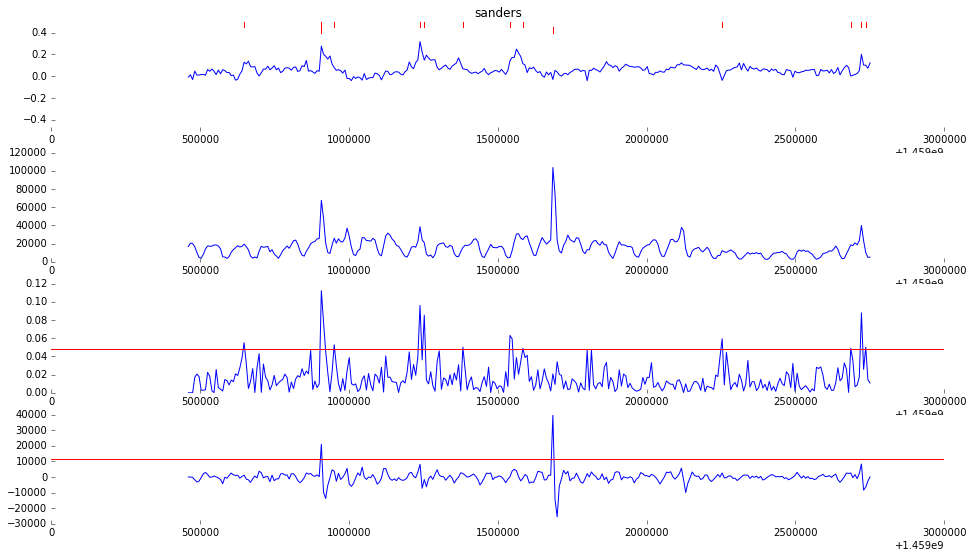

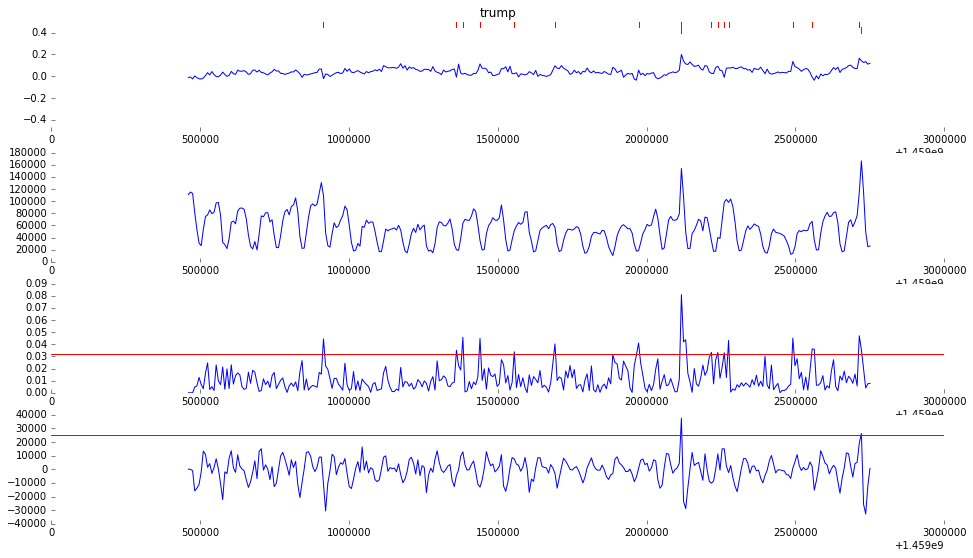

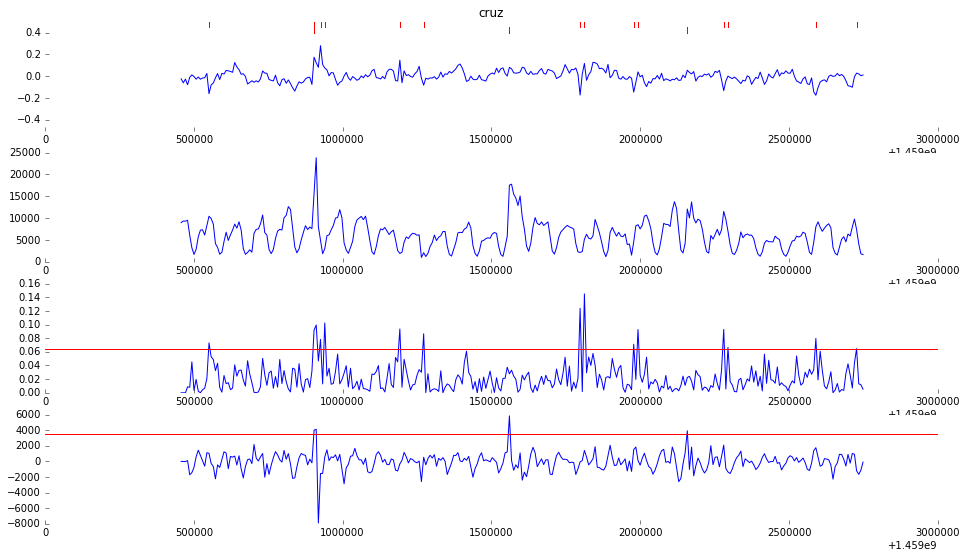

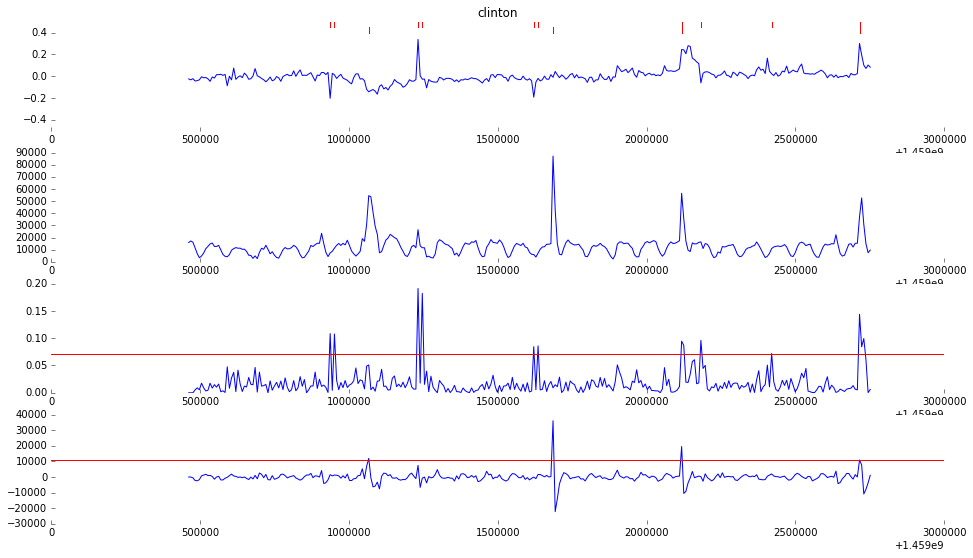

In [9]:
def diff_smooth(x, n):
    a = np.zeros_like(x)
    for i in range(int(round(n/2)),len(x)-n):
        i += n
        a[i] = np.nanmean(x[i-int(round(n/2)):i+int(round(n/2))], axis=0) - np.nanmean(x[i-n:i], axis=0)
    return a

def get_peaks(x, threshold):
    peaks = []
    peaking = False
    start = None
    for a in x:
        if not peaking:
            if a[1] > threshold:
                start = a[0]
                peaking = True
        elif peaking:
            if a[1] < threshold:
                end = a[0]
                peaks.append([start, end])
                start = None
                peaking = False
    return np.array(peaks)

candidates = ['sanders', 'trump', 'cruz', 'clinton']
viral_tweets = {}

for candidate in candidates:

    # get downsampled data
    conn = sqlite3.connect(sqlitefile_downsampled)
    c = conn.cursor()
    c.execute('''SELECT * FROM '''+candidate+''' WHERE datetime > 1459456469;''')
    # 1459456469 is the epoch time after which I started recording tweetIDs
    rows = c.fetchall()
    conn.close()

    rows = np.array(rows).astype(np.float32)
    
    data_downsampled = rows.copy()

    # calculate derivative of sentiment and tweets per bin
    data_diff = rows.copy()
    data_diff[:,1] = np.abs(diff_smooth(rows[:,1], 2))
    data_diff[:,2] = diff_smooth(rows[:,2], 1)

    # get peaks above a threshold
    sentiment_diff_threshold = np.std(data_diff[:,1])*3
    tps_diff_threshold = np.std(data_diff[:,2])*3
    sentiment_diff_peaks = get_peaks(data_diff[:,[0,1]], sentiment_diff_threshold)
    tps_diff_peaks = get_peaks(data_diff[:,[0,2]], tps_diff_threshold)
    
#     plot
    plt.figure(figsize=(16,9))
    plt.subplot(411)
    plt.title(candidate)
    plt.plot(data_downsampled[:,0], data_downsampled[:,1])
    for p in sentiment_diff_peaks:
        plt.axvline(x=p[0], ymin=0.95, ymax=1, c='r')
    for p in tps_diff_peaks:
        plt.axvline(x=p[0], ymin=0.9, ymax=0.95, c='r')
    plt.ylim([-0.5,0.5])
    plt.subplot(412)
    plt.plot(data_downsampled[:,0], data_downsampled[:,2])
    plt.subplot(413)
    plt.plot(data_diff[:,0], data_diff[:,1])
    plt.axhline(y=sentiment_diff_threshold, c='r')
    plt.subplot(414)
    plt.plot(data_diff[:,0], data_diff[:,2])
    plt.axhline(y=tps_diff_threshold, c='r')
    hide_spines()
    # plt.tight_layout()
    plt.show()

    # find most common tweetID of each peak
    if len(sentiment_diff_peaks) >= 1:
        if len(tps_diff_peaks) >= 1:
            peaks = np.sort(np.vstack((sentiment_diff_peaks, tps_diff_peaks)), axis=0)
        else:
            peaks = sentiment_diff_peaks
    else:
        peaks = tps_diff_peaks
    top_tweets = []
    prev_top_tweet = None
    for p in peaks:
        
        # get most common tweetID during the peak
        conn = sqlite3.connect(sqlitefile)
        c = conn.cursor()
        c.execute('''
        SELECT datetime, tweetID FROM '''+candidate+'''
        WHERE datetime BETWEEN '''+str('%f' % p[0])+'''
        AND '''+str('%f' % p[1])+''';
        ''')
        rows = c.fetchall()
        conn.close()

        rows = np.array(rows)
        
        if len(rows) < 1:
            continue

        (values,counts) = np.unique(rows[:,1],return_counts=True)
        ind=np.argmax(counts)
        top_tweet = values[ind]

        if top_tweet == None:
            continue

        # check if same tweet as previous peak
        if prev_top_tweet and top_tweet == prev_top_tweet:
            continue
        prev_top_tweet = top_tweet
        top_tweets.append({'datetime': int(np.mean(p)), 'tweetID': top_tweet})
    
    viral_tweets[candidate] = top_tweets

In [10]:
with open('../../jeroendelcour.nl/public/2016election/viraltweets.json', 'w') as f:
    json.dump(viral_tweets, f, indent=4)